In [1]:
from ELMo_Cache import *
from TemporalDataSet import *
from Baseline_LSTM import *
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from allennlp.modules.elmo import Elmo, batch_to_ids
from random import shuffle
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i
def evalOnTest(model,testset):
    confusion = numpy.zeros((len(output_labels),len(output_labels)),dtype=int)
    for temprel in testset.temprel_ee:
        embed = model.temprel2embeddingSeq(temprel).to(device)
        output = model(embed)
        confusion[output_labels[temprel.label]][categoryFromOutput(output)] += 1
    return 1.0*numpy.sum([confusion[i][i] for i in range(4)])/numpy.sum(confusion)

In [3]:
trainset = temprel_set("data/Output4LSTM_Baseline/trainset.xml")
testset = temprel_set("data/Output4LSTM_Baseline/testset.xml")

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

In [4]:
elmo = Elmo(options_file, weight_file, 1, dropout=0)
emb_cache = elmo_cache(elmo,"elmo_cache.pkl",False)

In [ ]:
embedding_dim = 256
hidden_dim = 32
position_emb_dim = 16
output_labels = {"BEFORE":0,"AFTER":1,"EQUAL":2,"VAGUE":3}
output_dim = len(output_labels)
batch_size = 1
position2ix = {"B":0,"M":1,"A":2,"E1":3,"E2":4}

model = lstm_baseline(embedding_dim,hidden_dim,position_emb_dim,emb_cache,output_dim,batch_size,position2ix)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

torch.manual_seed(1)
criterion = nn.CrossEntropyLoss()
allTempRels = trainset.temprel_ee
all_losses = []
all_accuracies = []

In [ ]:
start = time.time()
for epoch in range(20):
    print("epoch: %d" % epoch)
    current_loss = 0
    shuffle(allTempRels)
    for i in range(trainset.size):
        temprel = allTempRels[i]
        model.zero_grad()
        target = torch.tensor([output_labels[temprel.label]],dtype=torch.long).to(device)
        embed = model.temprel2embeddingSeq(temprel).to(device)
        output = model(embed)
        loss = criterion(output,target)
        current_loss += loss
        if i % 1000 == 0:
            print("%d/%d: %s %.4f %.4f" %(i,trainset.size, timeSince(start), loss, current_loss))
        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()
    print("Loss at epoch %d: %.4f" %(epoch,current_loss))
    all_losses.append(current_loss)
    all_accuracies.append(evalOnTest(model,testset))

epoch: 0
0/12740: 0m 0s 1.4898 1.4898
1000/12740: 0m 10s 1.0353 1127.2484
2000/12740: 0m 22s 3.4488 2222.1165
3000/12740: 0m 34s 0.7463 3279.1877
4000/12740: 0m 46s 1.0501 4315.5259
5000/12740: 0m 58s 1.0635 5392.3745
6000/12740: 1m 10s 0.4675 6405.2500
7000/12740: 1m 22s 1.2667 7428.4653
8000/12740: 1m 33s 1.2315 8447.1621
9000/12740: 1m 45s 1.1720 9468.6172
10000/12740: 1m 57s 1.4754 10463.1006
11000/12740: 2m 8s 0.4690 11406.2803
12000/12740: 2m 20s 0.5038 12333.9570
Loss at epoch 0: 13066.0723
epoch: 1
0/12740: 2m 46s 1.2537 1.2537
1000/12740: 2m 58s 2.0424 974.0793
2000/12740: 3m 10s 0.6769 1976.2921
3000/12740: 3m 22s 2.5179 2888.7478
4000/12740: 3m 34s 0.2387 3804.7407
5000/12740: 3m 46s 1.0509 4711.9468
6000/12740: 3m 58s 2.3322 5597.8579
7000/12740: 4m 10s 0.8518 6500.4297
8000/12740: 4m 22s 0.8708 7399.0278
9000/12740: 4m 34s 0.1938 8281.6973
10000/12740: 4m 46s 0.2164 9179.7236
11000/12740: 4m 58s 0.7296 10080.9961
12000/12740: 5m 10s 0.3622 10990.4385
Loss at epoch 1: 11666

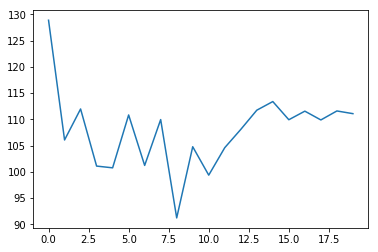

In [10]:
plt.figure()
plt.plot(all_losses)
plt.show()

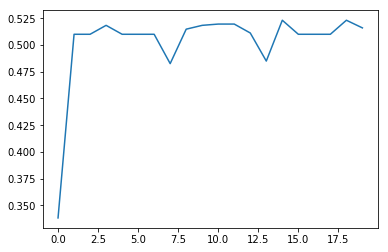

In [11]:
plt.figure()
plt.plot(all_accuracies)
plt.show()

In [23]:
confusion = numpy.zeros((len(output_labels),len(output_labels)),dtype=int)

testset = temprel_set("data/Output4LSTM_Baseline/testset.xml")
for temprel in testset.temprel_ee:
    output = model(temprel)
    confusion[output_labels[temprel.label]][categoryFromOutput(output)] += 1
print(confusion)

[[333  86   0   8]
 [ 74 194   0   3]
 [ 16  14   0   0]
 [ 72  35   0   2]]


In [20]:
print("%d/%d=%.2f\%",numpy.sum([confusion[i][i] for i in range(4)]),numpy.sum(confusion),1.0*numpy.sum([confusion[i][i] for i in range(4)])/numpy.sum(confusion))

837